Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

Use NSE custom objective.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190909-174938'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    #'max_depth': sp.stats.randint(2, 8),
    #'learning_rate': sp.stats.uniform(0.005, 0.1),
    #'gamma': sp.stats.uniform(0, 5),
    #'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.5, 0.5),
    #'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    #'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    #'reg_alpha': sp.stats.expon(0, 20),
    #'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
class NSEObjective:
    """Custom NSE XGBoost objective.
    
    This is a bit of a hack: We use a unique dummy target value for each sample, allowing us to look up
    the mean that corresponds to the sample's station.
    When calculating the loss, we replace the dummy with the actual target, so the model learns the right thing.
    """
    def __init__(self, dummy_target, actual_target, means, stations):
        self.dummy_target = dummy_target.to_numpy()
        self.actual_target = actual_target.to_numpy()
        self.means = means.to_numpy()
        self.stations = stations.to_numpy()
        
    def nse_objective(self, y_true, y_pred):
        """ NSE objective for XGBoost, slightly modified to normalize with mean """
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        means = self.means[indices]
        stations = self.stations[indices]
        grad, hess = np.empty(len(y_pred)), np.empty(len(y_pred))
        for station in np.unique(stations):
            station_mask = stations == station
            # normalize with mean instead of sum, because otherwise the gradients would be too small.
            normalization = np.mean(np.square(actual_target[station_mask] - means[station_mask]))
            grad[station_mask] = 2 * (y_pred[station_mask] - actual_target[station_mask]) / normalization
            hess[station_mask] = 2.0 / normalization
        return grad, hess
    
    def nse(self, y_pred, y_true, means):
        return np.sum(np.square(y_pred - y_true)) / np.sum(np.square(y_true - means))
    
    def nse_metric(self, y_pred, y_true):
        """ NSE metric for XGBoost """
        indices = np.searchsorted(self.dummy_target, y_true.get_label())
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return 'nse', nse / len(unique_stations)
    
    def neg_nse_metric_sklearn(self, estimator, X, y_true):
        """ -NSE metric for sklearn """
        y_pred = estimator.predict(X)
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return -nse / len(unique_stations)

In [5]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

data['dummy_target'] = range(len(data))
means = data.groupby('station')['runoff'].mean()
data = data.join(means, on='station', rsuffix='_mean')
nse_loss = NSEObjective(data['dummy_target'], data['runoff'], data['runoff_mean'], data['station'])

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target']), 
       (val.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), val['dummy_target'])]

xgb_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.08123625637629309, reg_alpha=3.7125525377954642, reg_lambda=0.0182830417835344, colsample_bylevel=0.9237069325689322, colsample_bytree=0.4540275483264704, gamma=0.9980644706841152, max_depth=7, min_child_weight=1, subsample=0.4831765844168827, objective=nse_loss.nse_objective, n_jobs=2, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=20, cv=2, return_train_score=True, scoring=nse_loss.neg_nse_metric_sklearn, n_jobs=40, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target'], eval_set=val, 
              eval_metric=nse_loss.nse_metric, early_stopping_rounds=100, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8775), val (4897, 8775), test (33580, 8775)
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   6 out of  40 | elapsed:  5.6min remaining: 31.7min
[Parallel(n_jobs=40)]: Done  15 out of  40 | elapsed:  7.2min remaining: 11.9min
[Parallel(n_jobs=40)]: Done  24 out of  40 | elapsed: 20.4min remaining: 13.6min
[Parallel(n_jobs=40)]: Done  33 out of  40 | elapsed: 21.8min remaining:  4.6min
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed: 22.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   param_subsample  mean_test_score  mean_train_score
4         0.859734        -0.579882         -0.387191
7         0.842415        -0.595967         -0.424128
3         0.775657        -0.600506         -0.434342
19        0.765914        -0.602468         -0.429157
18        0.765776        -0.602547         -0.432755
Best params: {'subsample': 0.8597344848927815}
mean_train_score   -0.387191
mean_test_score    -0.579882
Name: 4, dtype: object


02GA010 	NSE: 0.33306220478155635 	MSE: 317.9782991009668 (clipped to 0)
02GA018 	NSE: 0.36260325805683813 	MSE: 160.08421898066177 (clipped to 0)
02GA038 	NSE: 0.2888949279671792 	MSE: 117.00413126663244 (clipped to 0)
02GA047 	NSE: 0.2856447055584921 	MSE: 55.99832915059791 (clipped to 0)
02GB001 	NSE: 0.16568013940380044 	MSE: 6265.6380287928905 (clipped to 0)
02GB007 	NSE: 0.42652268674107563 	MSE: 17.933790872125666 (clipped to 0)
02GC002 	NSE: 0.5244437904803458 	MSE: 61.11041605589467 (clipped to 0)
02GC007 	NSE: 0.5272865233010093 	MSE: 14.238765469063152 (clipped to 0)
02GC010 	NSE: 0.519549156258339 	MSE: 28.562764127740195 (clipped to 0)
02GC018 	NSE: 0.47766010198971665 	MSE: 35.376410705130425 (clipped to 0)
02GC026 	NSE: 0.5635894293985977 	MSE: 70.18911365720228 (clipped to 0)
02GD004 	NSE: 0.4653917627576163 	MSE: 29.43717261445593 (clipped to 0)
02GE007 	NSE: 0.4205337997623011 	MSE: 20.96222368056688 (clipped to 0)
02GG002 	NSE: 0.5545470380648234 	MSE: 107.4356044000

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04166100 	NSE: 0.5800018777057054 	MSE: 3.0799754583777204 (clipped to 0)
04166500 	NSE: 0.5924291474851188 	MSE: 14.08739810279388 (clipped to 0)
04174500 	NSE: 0.4171509827974711 	MSE: 55.12250084671422 (clipped to 0)
04176500 	NSE: 0.2401726519263816 	MSE: 519.0184703642801 (clipped to 0)
04177000 	NSE: 0.3218073245536842 	MSE: 18.277177182376978 (clipped to 0)
04193500 	NSE: -0.08445461982271119 	MSE: 76780.19963041533 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04195820 	NSE: 0.12245700528072823 	MSE: 1030.0549961552758 (clipped to 0)
04196800 	NSE: 0.34718318613218146 	MSE: 195.35444382376113 (clipped to 0)
04197100 	NSE: 0.43247050785004804 	MSE: 58.20832737430353 (clipped to 0)
04198000 	NSE: 0.25131127498844097 	MSE: 5530.982429581655 (clipped to 0)
04199000 	NSE: 0.31007519906793024 	MSE: 705.5193780372201 (clipped to 0)
04199500 	NSE: 0.36624837010651223 	MSE: 256.446406825567 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04200500 	NSE: 0.27797323601070856 	MSE: 722.5357610221056 (clipped to 0)
04207200 	NSE: 0.43219876483658226 	MSE: 13.290121107742406 (clipped to 0)
04208504 	NSE: 0.4105113478588993 	MSE: 575.6525613046779 (clipped to 0)
04209000 	NSE: 0.45310362318927233 	MSE: 170.99044233792114 (clipped to 0)
04212100 	NSE: 0.37273737990246336 	MSE: 921.025410067334 (clipped to 0)
04213000 	NSE: 0.39703570633543406 	MSE: 108.21354135027214 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04213500 	NSE: 0.3793151672465931 	MSE: 635.839997125803 (clipped to 0)
04214500 	NSE: 0.5278038175072683 	MSE: 56.917152356172586 (clipped to 0)
04215000 	NSE: 0.47666185981194065 	MSE: 50.26810042095189 (clipped to 0)
04215500 	NSE: 0.5287736431967962 	MSE: 85.09636996180357 (clipped to 0)
Median NSE (clipped to 0) 0.4277093467555162 / Min -0.08445461982271119 / Max 0.6041371472179641
Median MSE (clipped to 0) 85.24453803271032 / Min 3.0799754583777204 / Max 76780.19963041533


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


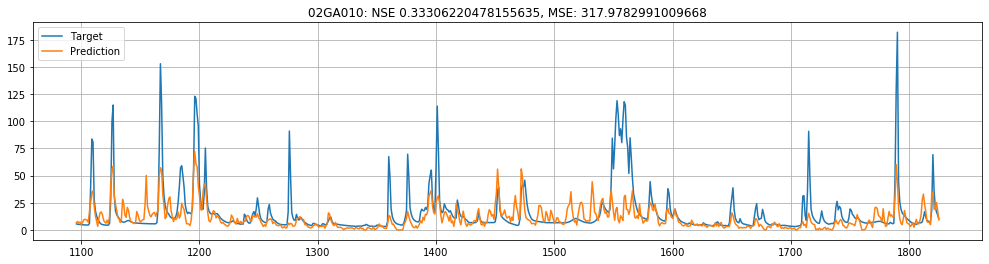

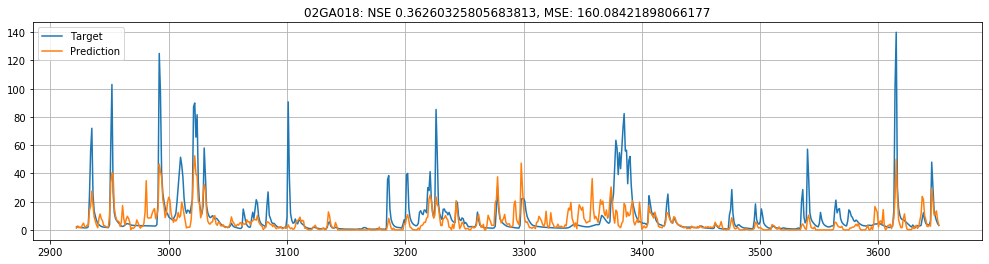

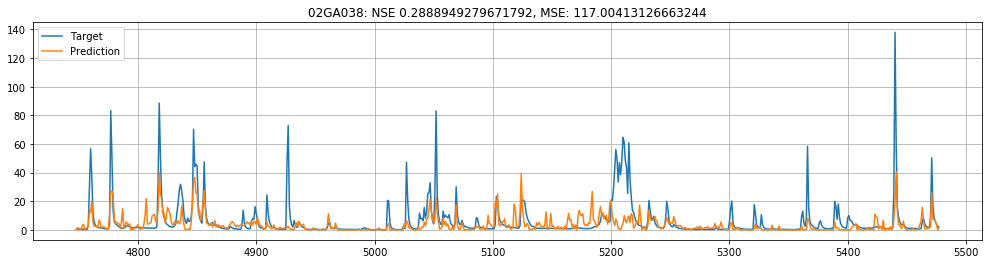

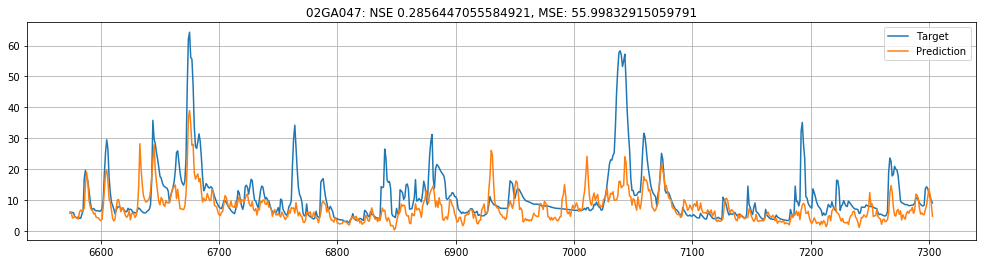

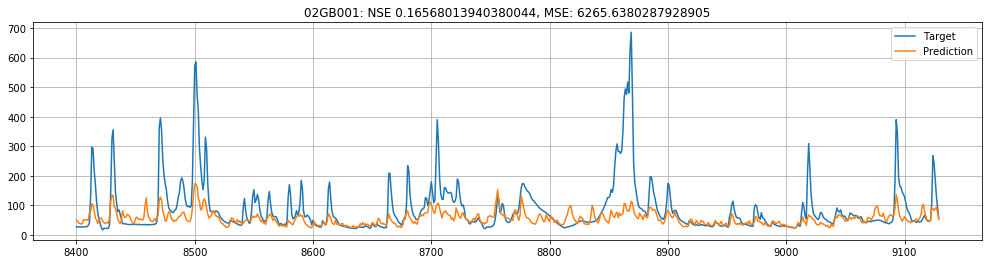

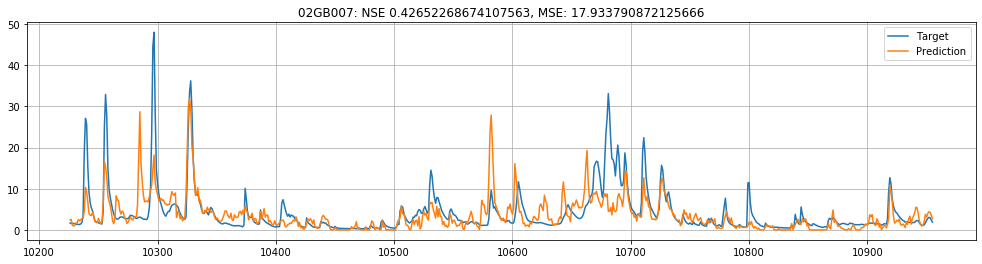

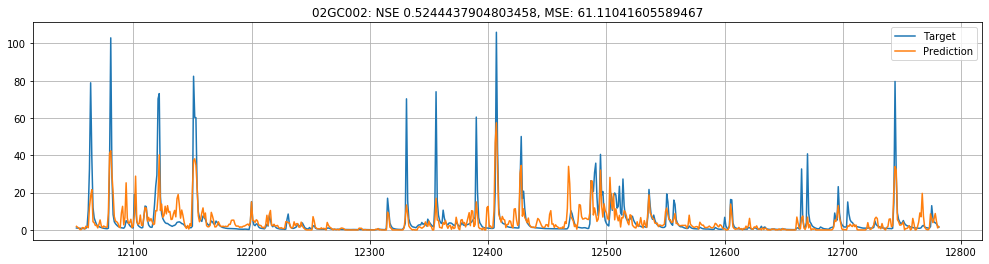

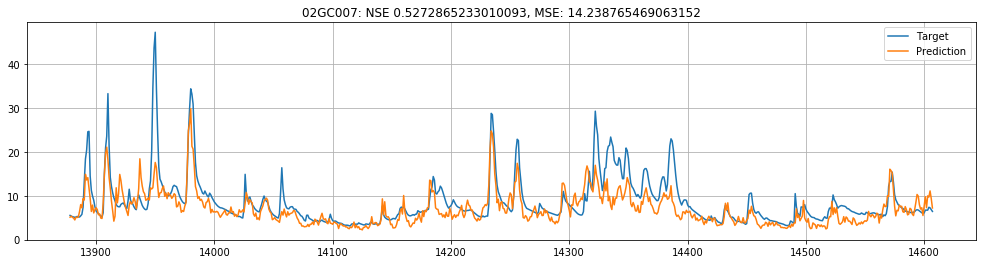

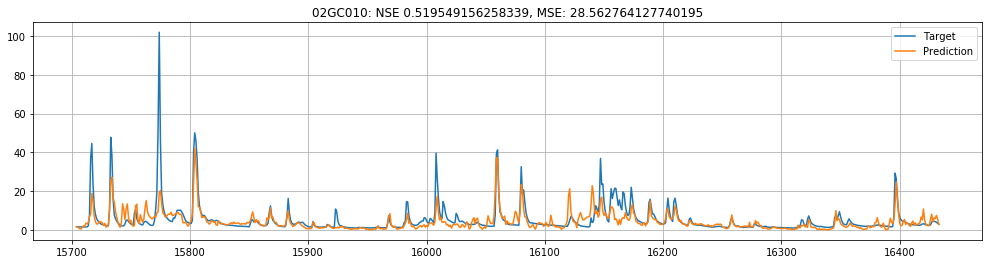

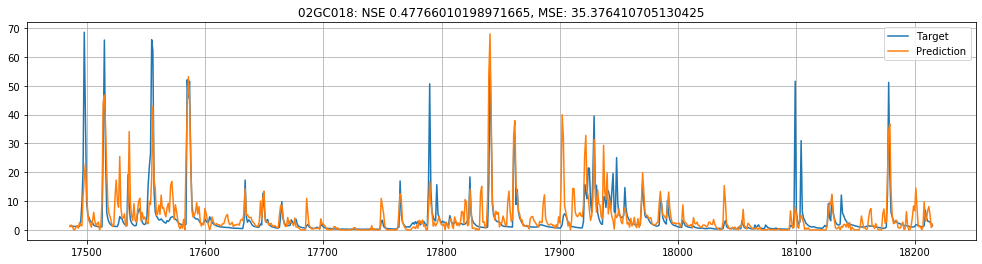

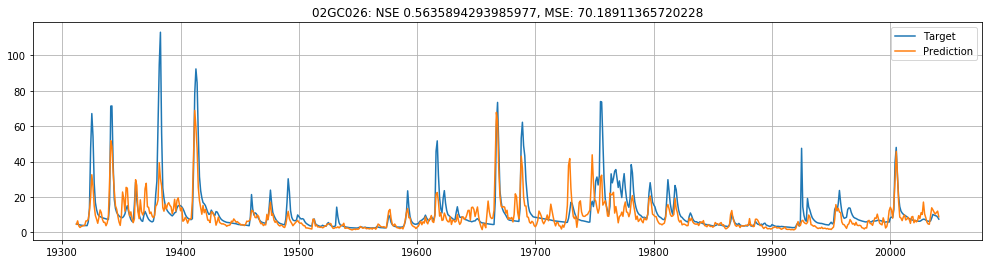

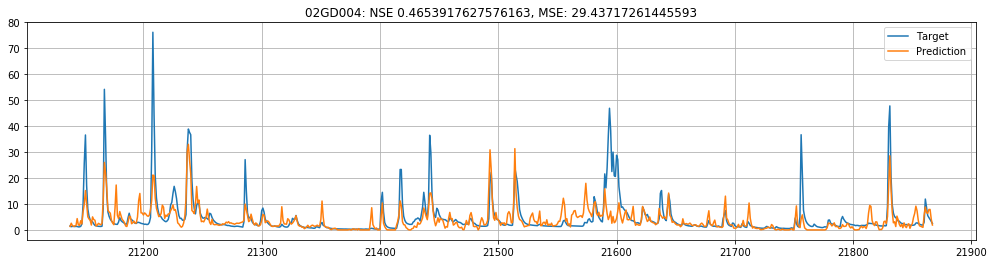

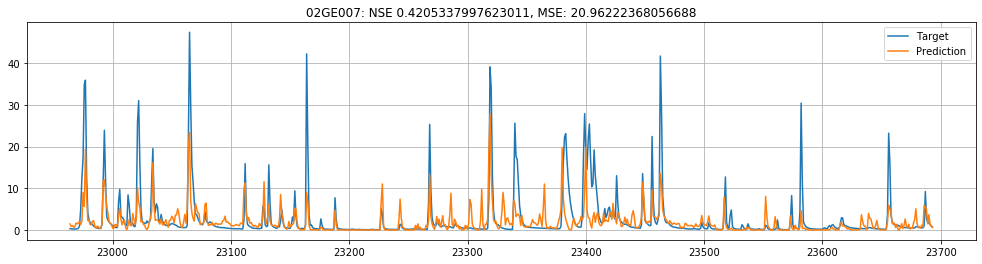

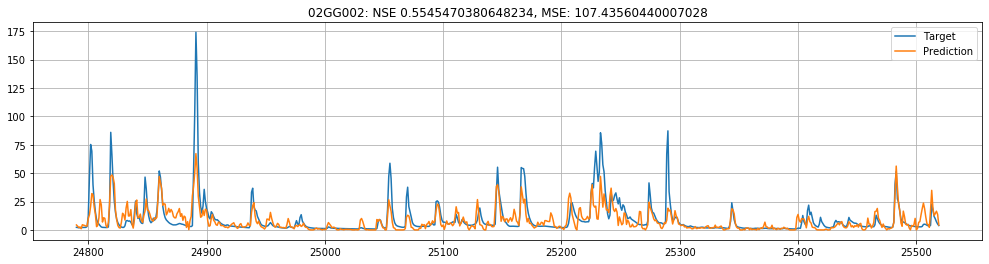

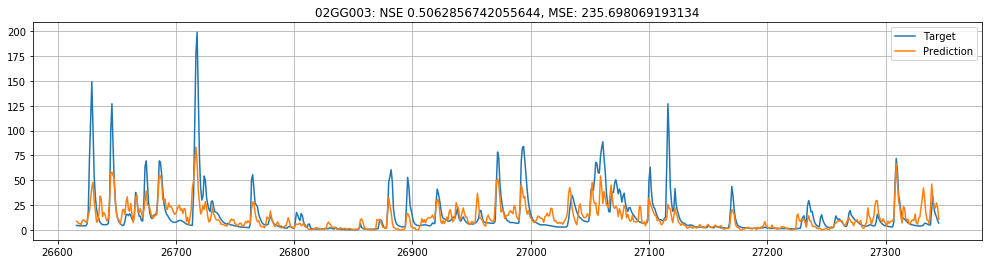

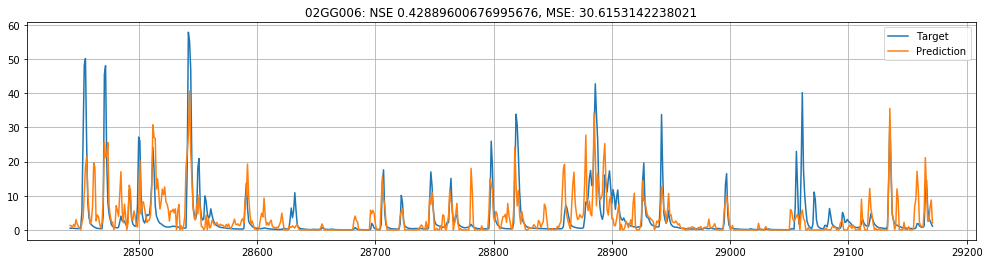

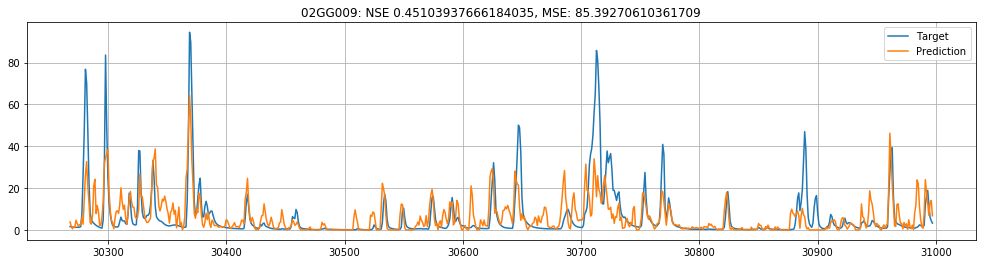

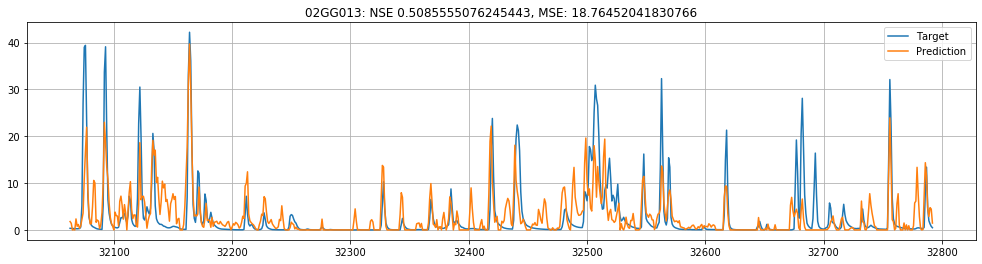

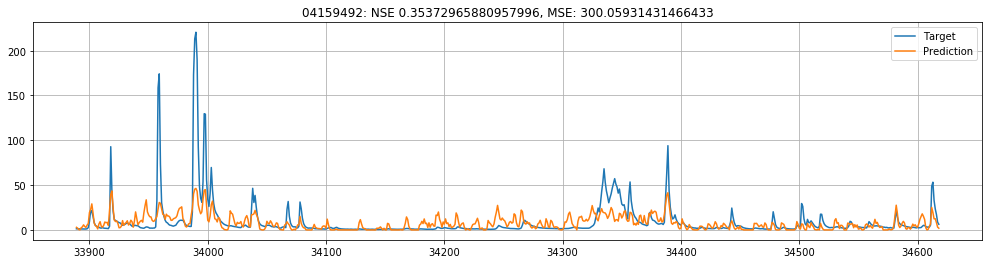

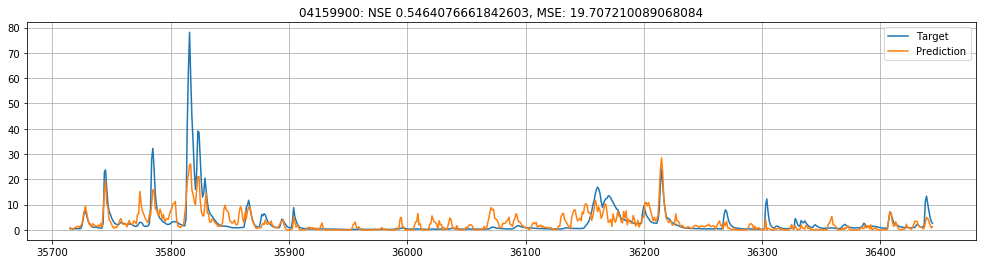

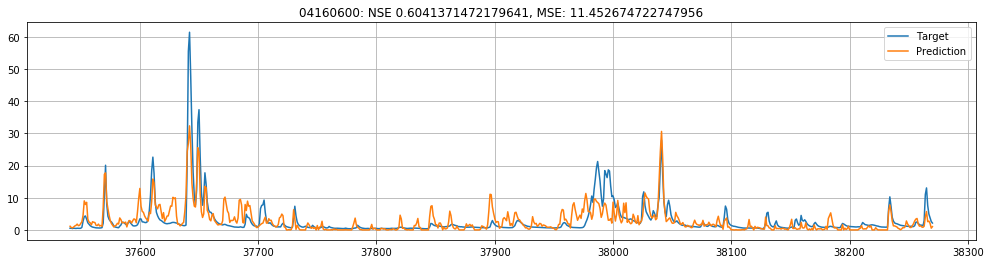

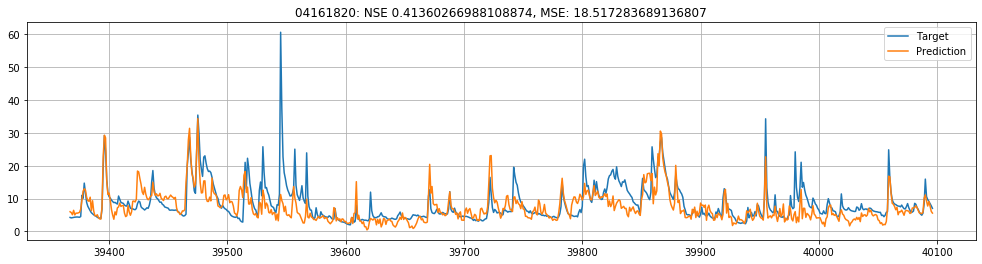

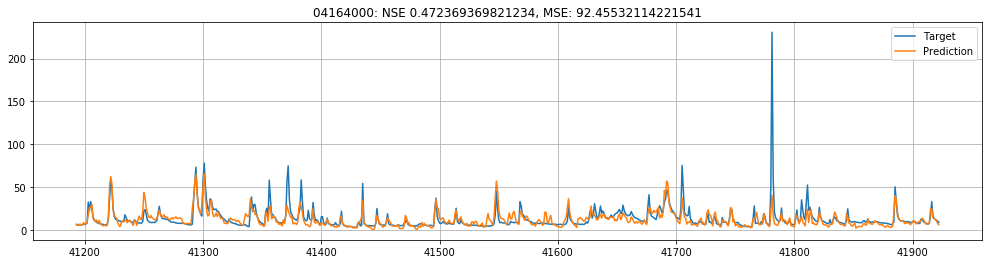

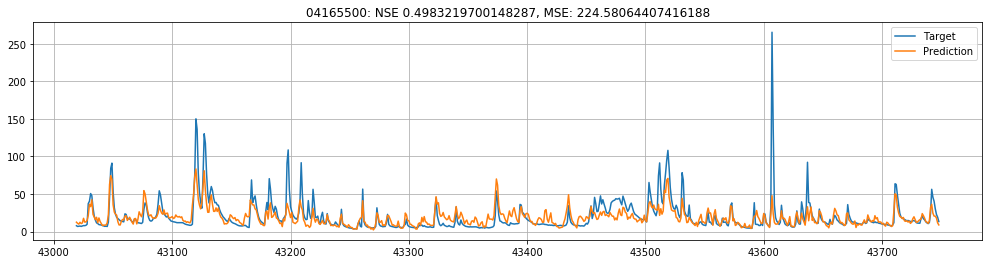

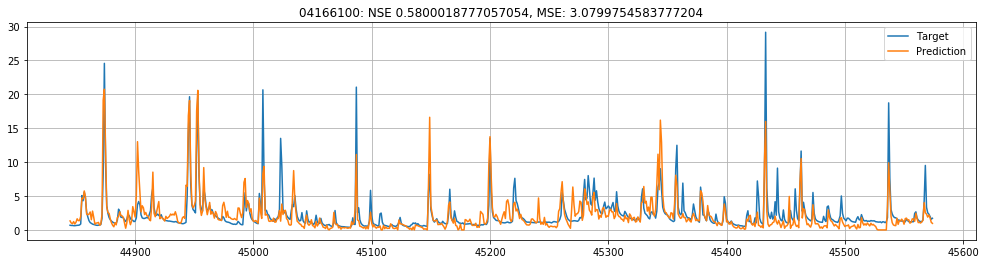

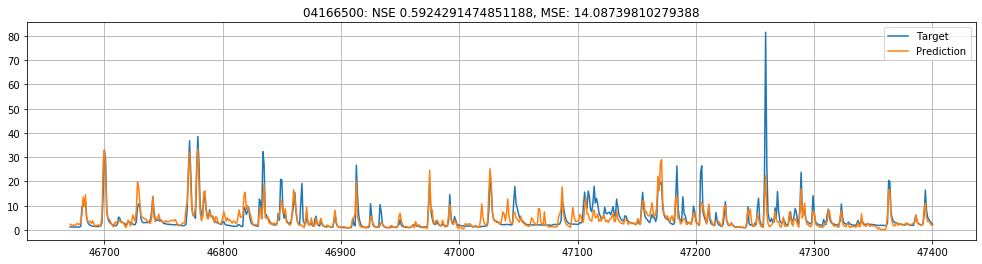

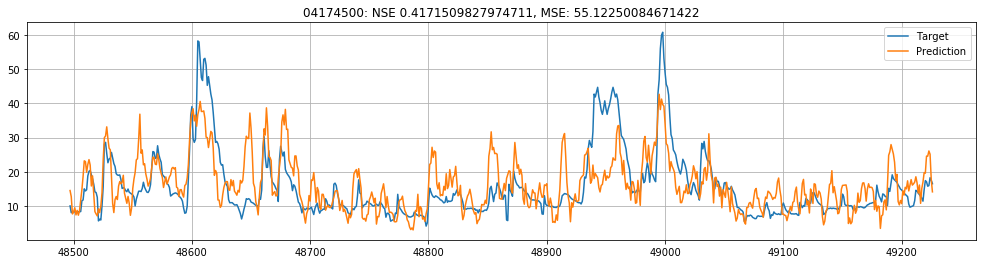

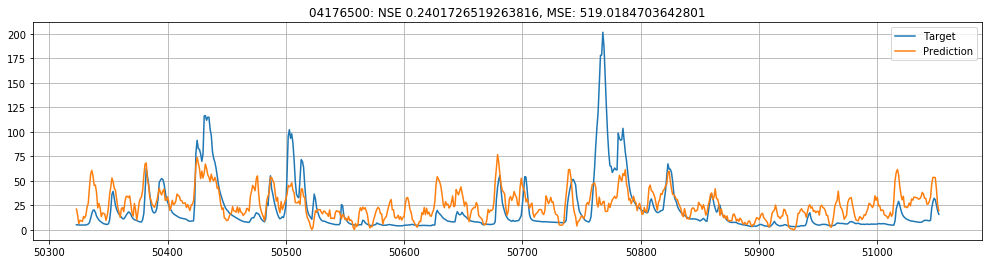

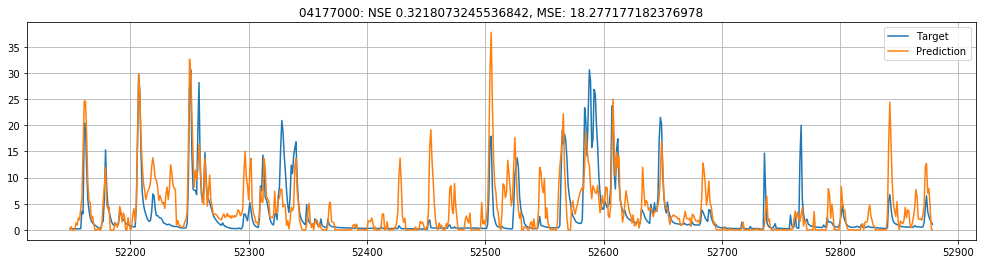

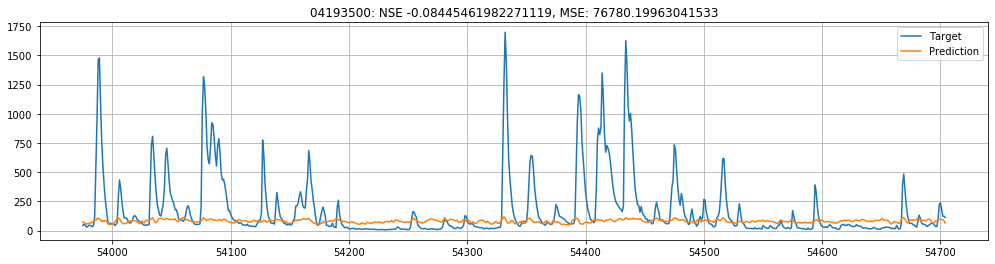

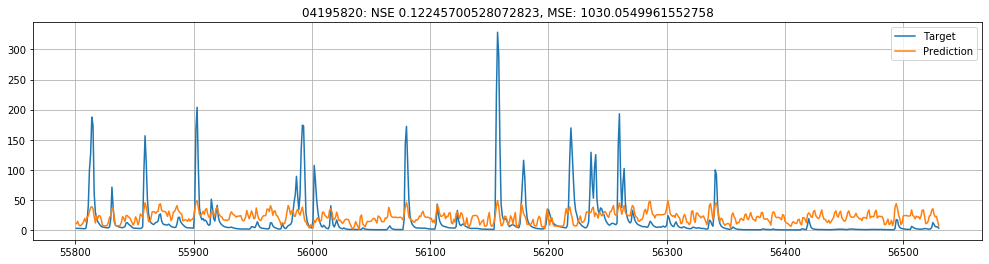

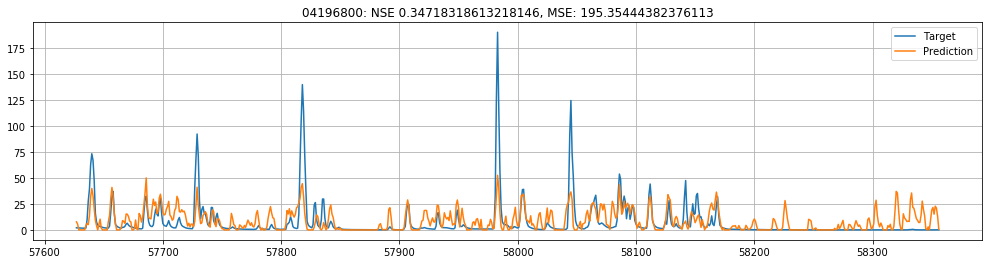

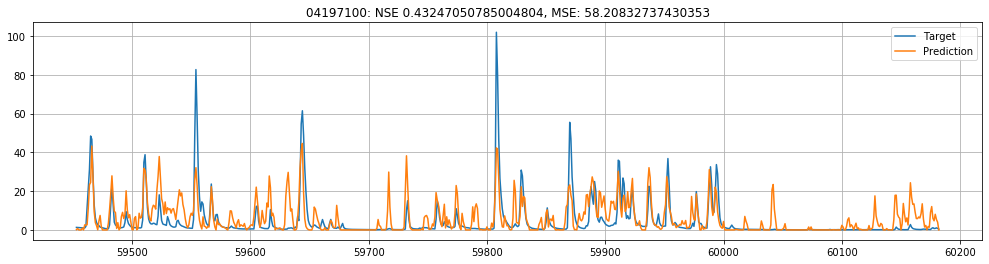

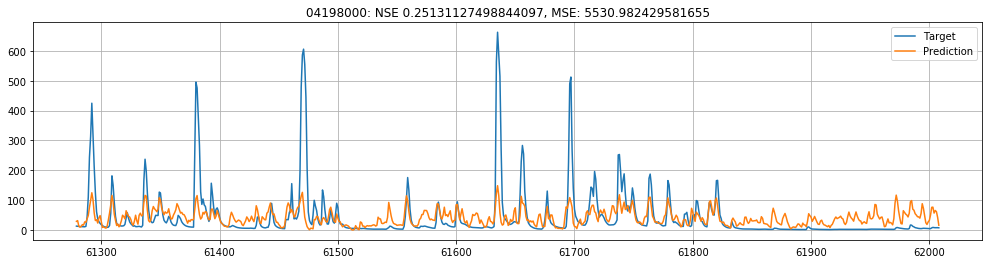

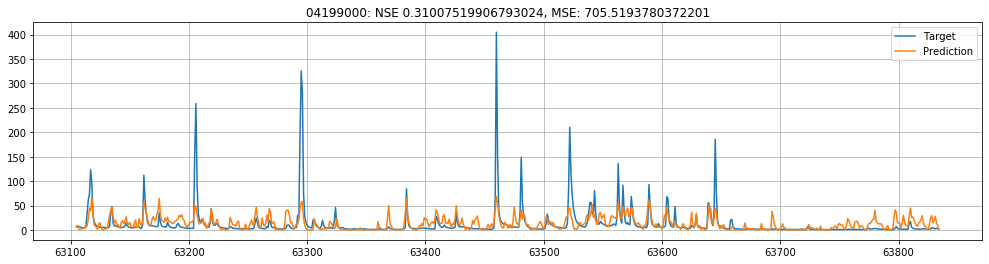

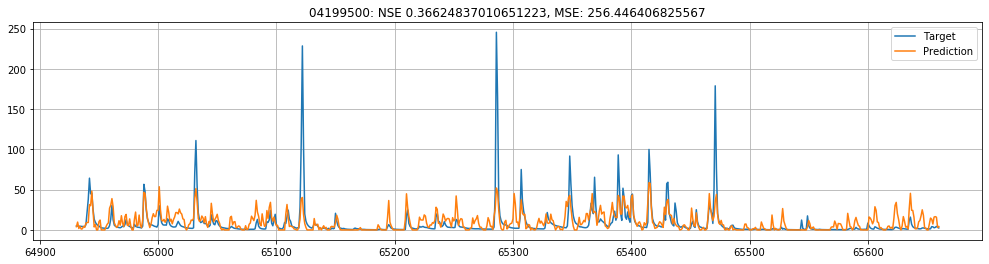

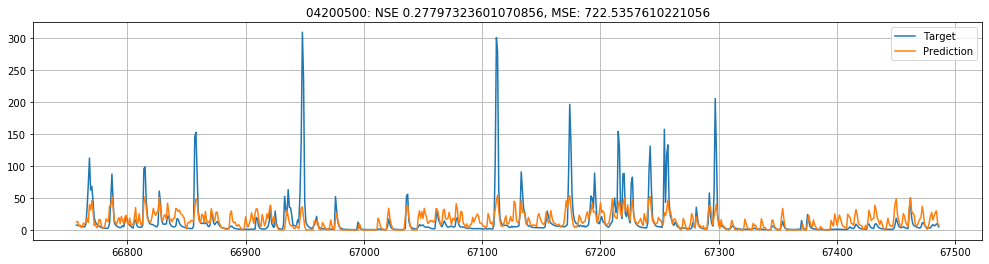

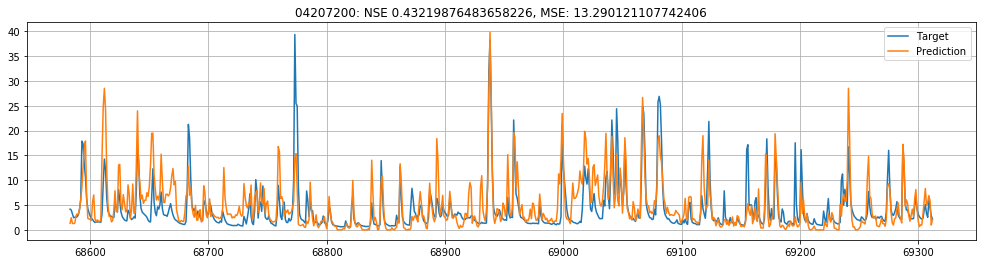

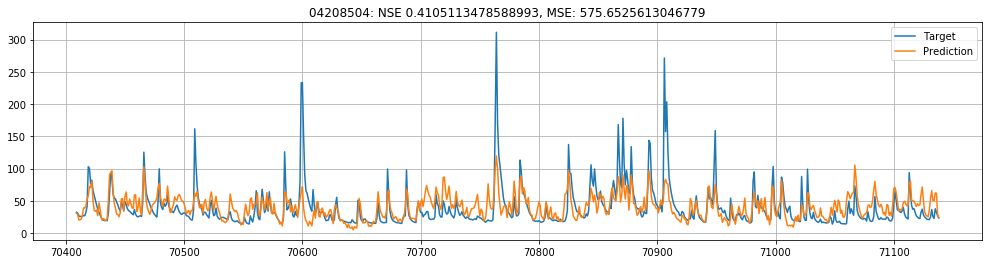

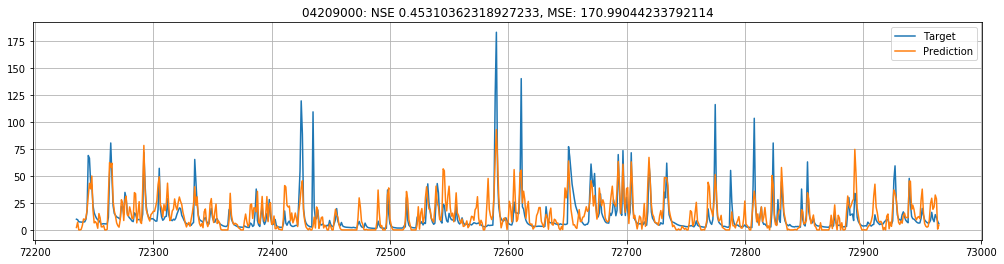

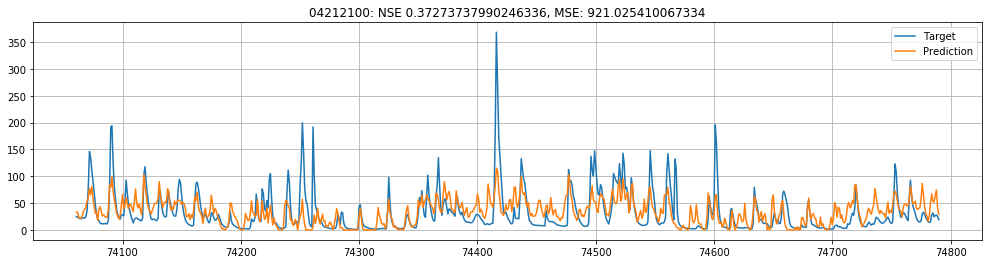

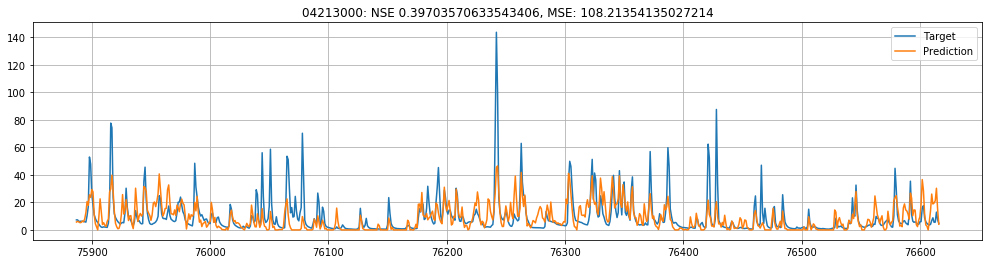

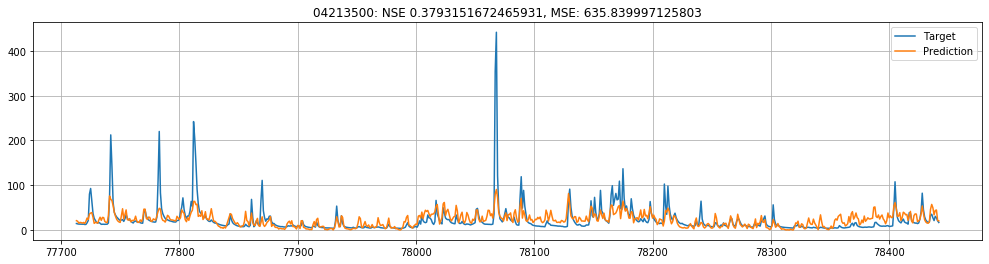

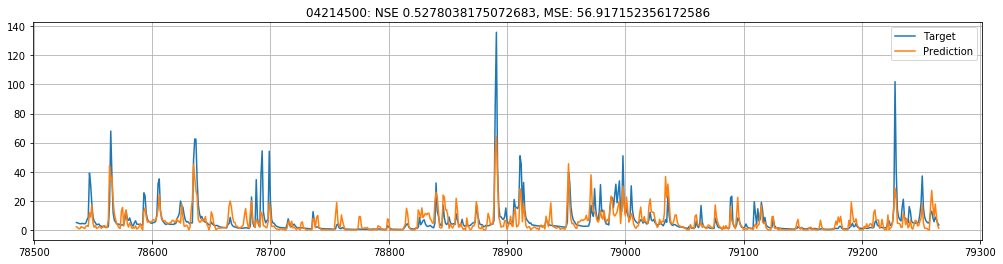

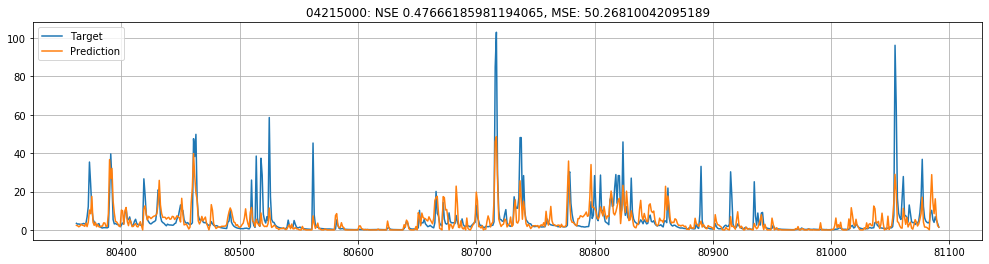

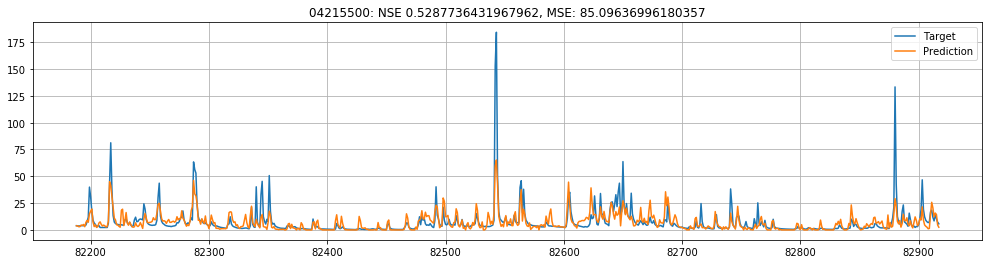

In [6]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [7]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel-NSELoss_20190909-174938.pkl'

In [8]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel-NSELoss_all_20190909-174938.pkl


In [9]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190909-184603'